# Facial Emotion Recognition - *face is the index of mind*

- Uses Deep Neural Nets to identify Facial Emotion.
- Classifies into one of 8 Emotions based on Paul Ekman 6 universal emotions.  
 **| neutral | happiness | surprise | sadness | anger | disgust | fear | contempt |**
- Kaggle Competition with human labeled dataset in 2013.
- Microsoft researchers crowd sourced tags(labels) - FER+ Dataset.

- We are always judging each other sometimes just by looking at each other's face.
- Paul Ekman American psychologist identified 6 emotions that are universal across different cultures and developed a coding mechanism FACS(Facial Action coding scheme)
- Microsoft researchers relabeled the dataset using crowding sourcing, they applied different approaches such as majority-voting, multi-labeling, probablistic label drawing and cross-entropy loss.
- Without going into the details of the paper, a few things to note 

## FER+
- Used Convolutional Neural Nets and VGG13 as the DNN network.
- Used Cross Entropy to measure the loss.
- FER+ has new corrected labels
- Preprocess the dataset by augmenting the images -  {crop faces, scale, shift, normalize, ..}

## References
- [FER from scratch using Apache MXNet](https://github.com/TalkAI/facial-emotion-recognition-gluon)
- Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution https://arxiv.org/abs/1608.01041

## Transfer Learning
- Small Datasets - Overfitting
- Start with a pre-trained model, instead of from scratch - **knowledge transfer**
- Saves cost and time on labeling efforts.

## Import necessary libraries

In [1]:
 import mxnet as mx
import numpy as np
import os, time, shutil
import zipfile, os
from gluoncv.utils import download

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs

In [2]:
# Download the dataset
data_url = 'https://s3.amazonaws.com/odsc-conf/data.zip'
data_zip = download(data_url, path='./')
with zipfile.ZipFile(data_zip, 'r') as zipped_data:
    zipped_data.extractall(os.path.expanduser('./'))

In [3]:
processed_train_images = np.load('./data/fer_train_processed_images.npy')
processed_train_labels = np.load('./data/fer_train_processed_labels.npy')
processed_test_images = np.load('./data/fer_test_processed_images.npy')
processed_test_labels = np.load('./data/fer_test_processed_labels.npy')
processed_val_images = np.load('./data/fer_val_processed_images.npy')
processed_val_labels = np.load('./data/fer_val_processed_labels.npy')

train_labels = np.argmax(processed_train_labels, axis=1)
val_labels = np.argmax(processed_val_labels, axis=1)
test_labels = np.argmax(processed_test_labels, axis=1)

# FER Data


In [4]:
print(processed_train_images.shape, processed_train_labels.shape) 

(25045, 1, 64, 64) (25045, 8)


In [5]:
emotions = {0: 'neutral', 1: 'happiness', 2: 'surprise',3: 'sadness',
            4: 'anger', 5: 'disgust', 6: 'fear', 7: 'contempt'}

In [6]:
from matplotlib import pyplot as plt
plt.imshow(processed_train_images[100].reshape(64,64), cmap='gray')
print(processed_train_labels[100])
print(emotions[np.argmax(processed_train_labels[100])])

[ 1.  0.  0.  0.  0.  0.  0.  0.]
neutral


In [7]:
from multiprocessing import cpu_count

CPU_COUNT = cpu_count()

per_device_batch_size = 64

num_gpu_range = mx.test_utils.list_gpus()

ctx = [mx.gpu(i) for i in num_gpu_range] \
if num_gpu_range.stop > num_gpu_range.start else mx.cpu()

batch_size = per_device_batch_size* max(num_gpu_range.stop, 1)


print('num_cpu: {}, num_gpus: {},\n ctx: {}, batch_size:{}'.format(CPU_COUNT, num_gpu_range.stop, ctx, batch_size))

num_cpu: 32, num_gpus: 4,
 ctx: [gpu(0), gpu(1), gpu(2), gpu(3)], batch_size:256


## Dataset, DataLoader and Transforms
[Dataset](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.Dataset) - used to represent collection of data, includes methods to load/parse data on disk.  
[DataLoader](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.DataLoader) - mini-batches of data from Dataset, iterator interface, can load data in parallel.  
[Transforms](https://mxnet.incubator.apache.org/api/python/gluon/data.html#vision-transforms) - Transformations that can applied on data for augmentation, multiple transforms can composed to apply sequentially on the data. 

## Transforms 

### 1. Gray scale to 3 Channel


In [8]:
gray_to_3channel = lambda x: nd.concat(nd.array(x), \
                        nd.array(x), nd.array(x), dim = 0)

### 2. Resize images from (64x64) to (224 x224)

In [9]:
center_pad = lambda x: nd.pad(nd.array(x).expand_dims(axis=0),\
      'constant',pad_width=(0, 0, 0, 0, 80,80, 80,80)). \
      squeeze().expand_dims(axis=0)

### 3. Compose a transformer

In [10]:
transformer = transforms.Compose([center_pad, gray_to_3channel])

# DataLoader

In [11]:
train_data = gluon.data.DataLoader(gluon.data.ArrayDataset \
(processed_train_images, train_labels).transform_first(transformer),
batch_size, shuffle=True, num_workers=CPU_COUNT)

val_data = gluon.data.DataLoader(gluon.data.ArrayDataset \
(processed_val_images, val_labels).transform_first(transformer),
batch_size, shuffle=True, num_workers=CPU_COUNT)

test_data = gluon.data.DataLoader(gluon.data.ArrayDataset \
(processed_test_images, test_labels).transform_first(transformer),
batch_size, shuffle=True, num_workers=CPU_COUNT, last_batch='discard')

In [12]:
data_shape = None
label_shape = None
for X_batch, y_batch in train_data:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))
    data_shape = X_batch.shape
    label_shape = y_batch.shape
    break

X_batch has shape (256, 3, 224, 224), and y_batch has shape (256,)


## Use Pretrained VGG13 model from GluonCV Model Zoo

In [13]:
model_name = 'vgg13'
from gluoncv.model_zoo import get_model
net = get_model(model_name, pretrained=True)

Model file is not found. Downloading.


483483KB [00:09, 50852.63KB/s]                            


In [14]:
net

VGG(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (15): Conv2D(256 -> 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): Acti

### Change the number of classes in the output layer


In [15]:
classes = 8
with net.name_scope():
    net.output = nn.Dense(classes)

### Initialize the Parameters of the Output Layer(only) using Xavier

In [16]:
net.output.initialize(init.Xavier(), ctx = ctx)

In [17]:
# Re assign parameters to other contexts
net.collect_params().reset_ctx(ctx)
# Hybridize
net.hybridize()

## Verify the shapes 

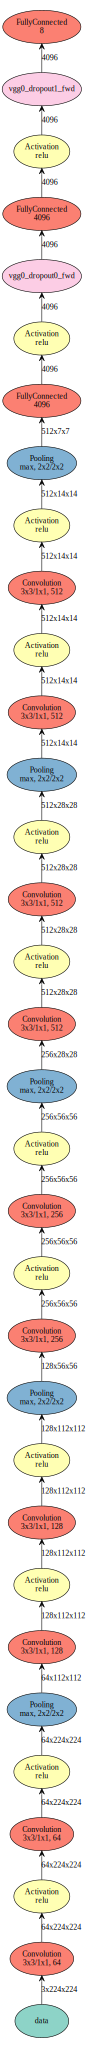

In [18]:
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym, \
                    node_attrs={"shape":"oval","fixedsize":"false"}, \
                    shape={"data": data_shape})

## HyperParameters

In [19]:
epochs = 10
lr = 0.01
momentum = 0.9

## Create a Trainer

In [20]:
trainer = gluon.Trainer(net.collect_params(), 'sgd',
           {'learning_rate': lr, 'momentum': momentum})

In [21]:
metric = mx.metric.Accuracy()
L = gluon.loss.SoftmaxCrossEntropyLoss()

## Validation Loop

In [22]:
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

## Training Loop

In [23]:
num_batch = len(train_data)

train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):

    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        # use gluon.utils.split_load to load a slice of the mini-batch to each context
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        with ag.record():
            # pass each slice of dadata to the network's forward pass and collect output            
            outputs = [net(X) for X in data]
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        # for each loss, compute gradients            
        for l in loss:
            l.backward()
        trainer.step(batch_size)
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        metric.update(label, outputs)

    _, train_acc = metric.get()
    train_loss /= num_batch
    
    _, val_acc = test(net, val_data, ctx)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

[Epoch 0] Train-acc: 0.603, loss: 1.127 | Val-acc: 0.717 | time: 93.8
[Epoch 1] Train-acc: 0.733, loss: 0.783 | Val-acc: 0.740 | time: 44.9
[Epoch 2] Train-acc: 0.774, loss: 0.658 | Val-acc: 0.770 | time: 45.1
[Epoch 3] Train-acc: 0.823, loss: 0.516 | Val-acc: 0.798 | time: 45.3
[Epoch 4] Train-acc: 0.859, loss: 0.411 | Val-acc: 0.808 | time: 45.2
[Epoch 5] Train-acc: 0.882, loss: 0.342 | Val-acc: 0.794 | time: 45.2
[Epoch 6] Train-acc: 0.923, loss: 0.230 | Val-acc: 0.792 | time: 45.0
[Epoch 7] Train-acc: 0.937, loss: 0.183 | Val-acc: 0.806 | time: 44.8
[Epoch 8] Train-acc: 0.956, loss: 0.124 | Val-acc: 0.805 | time: 44.8
[Epoch 9] Train-acc: 0.959, loss: 0.115 | Val-acc: 0.786 | time: 45.1


## Training and Validataion Loss/Accuracy 

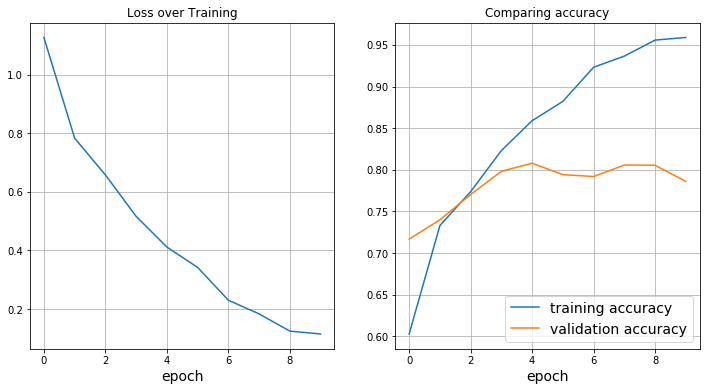

In [24]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(range(epochs), train_losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(range(epochs), train_accuracies)
p2, = fg2.plot(range(epochs), val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14)

## Test Accuracy

In [25]:
_, test_acc = test(net, test_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.783


In [26]:

from PIL import Image
import numpy as np

def readImage(file_name):
    """
    Decodes an Image bytearray into 3-D numpy array.
    """
    from PIL import Image
    import numpy as np
    import io
    from array import array
    # read the bytearray using OpenCV and convert to RGB
    img = Image.open(file_name)
    img = img.convert('RGB')
    #resize the image to 224x224
    img = img.resize((224, 224), Image.ANTIALIAS)
    # reshape the array from (height, width, channel) to (channel, height, width)
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    # add a new axis to hold a batch of images.
    img = img[np.newaxis, :]
    return img


In [27]:
from matplotlib.pyplot import imshow
def showImage(file_name):
    img = Image.open(file_name)
    imshow(np.asarray(img))

### Run Prediction on './data/test.jpg' using the trained model above,  

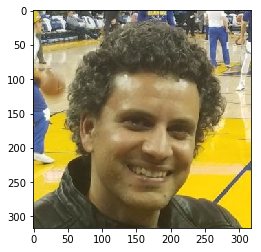

In [28]:
showImage('./data/test.jpg')

In [29]:
# Use the readImage routine above
test_img = readImage('./data/test.jpg')

In [30]:
# verify Input Image shape
test_img.shape

(1, 3, 224, 224)

In [31]:
# get the input image to one of the contexts
test_nd = nd.array(test_img, ctx[0])

# Predict by running forward pass on the network,
# simply pass the input data net
test_out = net(test_nd)

# remove single-dimension axis and copy from GPU(if exists) to numpy array
test_out = test_out.squeeze().asnumpy()

# label corresponding to output
a = np.argsort(test_out)[::-1]

for i in a:
    print('probability = {:f}, class = {}\n'.format(test_out[i], emotions[i]))

probability = 207.725571, class = happiness

probability = 110.890465, class = neutral

probability = 47.247025, class = anger

probability = 8.289546, class = surprise

probability = -13.182712, class = contempt

probability = -60.989773, class = sadness

probability = -111.577095, class = disgust

probability = -200.844727, class = fear

